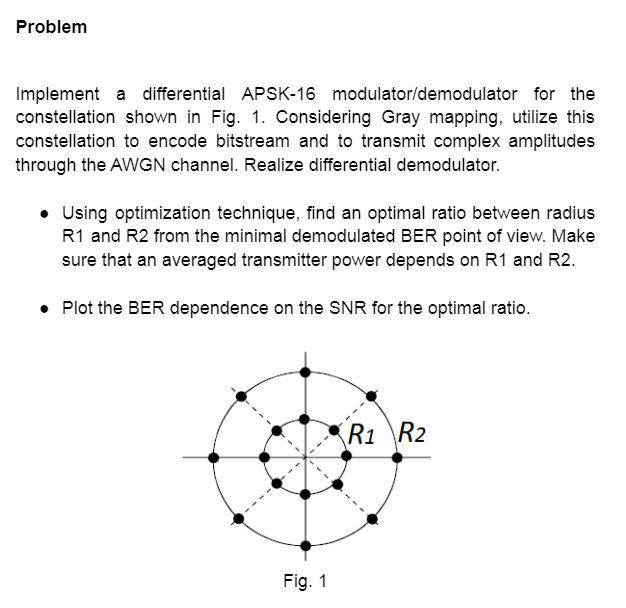

At first, let's implement an APSK-16 constellation. 
As we have to keep the same value of the transmission power we can assume that radiuses of constellations can be calculated from the following law:
$$
R_1^2 + R_2^2 = 1
$$
To make it correct let's assume: 
$$
R_{ratio} = \frac{R_2}{R_1}
$$
As a result, radiuses can be calculated as follows:
$$
R_1 = \sqrt{(1+R_{ratio}^2)^{-1}} , \hspace{1cm}
R_2 = R_{ratio} \cdot R_1
$$

Points of the constellation can be represented with the following equation:
$$
z_{m,n} = R_n(\cos(\alpha_m) + j\sin{(\alpha_m)}), \\
$$
where
$$
\alpha_m \in m\frac{\pi}{8}, \hspace{1cm}  m \in [0,7] , \hspace{1cm}   n \in [1,2]
$$
Here $m$ is the number of points on each radius and $n$ is the number of radiuses.

Also, let's normalize constellation power for convenience to be sure that it's equal to 1 during our experiments:
$$
P = \frac{1}{16}\sum_{n}\sum_{m} z_{m,n} z_{m,n}^* \\
a_{m,n} = \frac{z_{m,n}}{\sqrt{P}}  
$$
where $a_{m,n}$ are normalized values. 

Also, we have to implement Gray mapping for our constellation to have Hamming distance between each 2 neighbor constellation points not bigger than 1.
This codebook was implemented by hand and during the initialization process, binary sequences match to complex coordinates of each constellation point.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Constellation():
    def __init__(self, r_ratio, norm = True):
        '''
        initialization of constellation
        @r_ratio - R2/R1 ratio
        @norm - if True - normalization will be applied
        '''

        # number of points on each radius
        self.n_elements = 8
        # number of all points
        self.n_all_elements = self.n_elements * 2
        self.r_ratio = r_ratio
        # getting sizes of radiuses
        self.__init_radiuses()
        # creating angle for each constellation point 
        self.angles = np.linspace(0, 2*(1-1/8)*np.pi, self.n_elements)
        # creation constellation points
        self.__create()
        
        # normalization
        if norm:
            self.__normalize() 

        # creating of codebook with Gray code
        self.__init_gray_mapping()


    def __init_gray_mapping(self):
        '''
        initialization of Gray sequences @gray_map
        Match each coordinates of constellation points with binary sequence 
        Also creates codebook for demapping @gray_demap
        '''
        self.gray_map= {
        (1,1,0,0) : 0,
        (1,1,0,1) : 0,
        (1,0,0,1) : 0,
        (1,0,0,0) : 0,
        (0,0,0,0) : 0,
        (0,0,0,1) : 0,
        (0,1,0,1) : 0,
        (0,1,0,0) : 0,
        (1,1,1,0) : 0,
        (1,1,1,1) : 0,
        (1,0,1,1) : 0,
        (1,0,1,0) : 0,
        (0,0,1,0) : 0,
        (0,0,1,1) : 0,
        (0,1,1,1) : 0,
        (0,1,1,0) : 0
        }

        # matching with constellation points
        for idx, key in enumerate(self.gray_map.keys()):
            self.gray_map[key] = self.points[idx]
        
        # demapping codebook
        self.gray_demap = dict((val,key) for key,val in self.gray_map.items())


    def __get_mapped_labels(self):
        '''
        return labels for graphs with binary code
        so it makes str from tuples
        '''
        return [str(key).replace(",","").replace("(","").replace(")","").replace(" ","") for key in self.gray_map.keys()]


    def __init_radiuses(self):
        '''
        Initialization of radiuses, using r_ratio value
        '''
        self.R1 = np.sqrt(1/(1 + self.r_ratio**2))
        self.R2 = self.r_ratio*self.R1


    def __create(self):
        '''
        Creates contellation points
        '''
        half_idxs = self.n_all_elements // 2
        self.points = np.empty(self.n_all_elements, dtype = 'complex64')
        self.points[:half_idxs] = self.R1 * (np.cos(self.angles[:half_idxs]) + 1j*np.sin(self.angles[:half_idxs]))
        self.points[half_idxs:] = self.R2 * (np.cos(self.angles[:half_idxs]) + 1j*np.sin(self.angles[:half_idxs]))


    def get_power(self):
        '''
        Returns power of the constellation points
        '''
        return np.mean(np.dot(self.points, self.points.conj())).real


    def __normalize(self):
        '''
        Applies normalization of power for constellation points
        '''
        P = self.get_power()
        norma = np.sqrt(P)
        self.points /= norma


    def demapping(self, data):
        '''
        Applies demapping from data to bitstream
        '''
        # distance calculation
        dist = abs(data.reshape((-1,1)) - self.points.reshape((1,-1)))
        # index of the nearest constellation point
        nearest_idx = dist.argmin(axis = 1)
        # value of this point
        demapped = self.points[nearest_idx]
        # stacking values
        demapped_group = np.vstack([self.gray_demap[element] for element in demapped])
        return  demapped_group, demapped
        

    def plot(self, mapping = False):
        '''
        plots constellation graph 
        '''
        fig, ax = plt.subplots(figsize =(9,9))
        c1 = plt.Circle((0,0), self.points[0].real,color = 'k', fill = False,alpha = 0.5)
        c2 = plt.Circle((0,0), self.points[12].real, color = 'k',alpha = 0.5, fill = False)

        ax.set_title("16APSK", fontsize = 15)
        ax.set_xlabel("Real", fontsize = 14)
        ax.set_ylabel("Imag", fontsize = 14)
        ax.add_patch(c1)
        ax.add_patch(c2)
        ax.axhline(0, linestyle='--', color='k',alpha = 0.5)
        ax.axvline(0, linestyle='--', color='k', alpha = 0.5)
        ax.scatter(self.points.real , self.points.imag,zorder =5, s =90, color= 'r', alpha = 0.9)

        if mapping:
            labels = self.__get_mapped_labels()
            for i,point in enumerate(self.points):
                 plt.text(point.real - 0.03, point.imag + 0.02, labels[i], fontsize=16)
        shift = 0.07
        plt.xlim(-self.R1+shift, self.R1-shift)
        plt.ylim(-self.R1+shift, self.R1-shift)


In [ ]:
def generate_data(n_bits):
    '''
    creates random bitstream and reshapes it to bin sequences of 4 elements
    '''
    bits = np.random.binomial(n=1, p=0.5, size=n_bits)
    return bits.reshape(len(bits) // 4, 4)

def map_data(data, codebook):
    '''
    Applies data mapping with Gray codes
    '''
    return np.array([codebook[tuple(b)] for b in data])

def generate_mapped(n_bits,codebook):
    '''
    Generate mapped data
    '''
    return map_data(generate_data(n_bits), codebook)

def get_ber(true_values, real_values ):
    '''
    Ber calculation
    '''
    return np.mean(true_values != real_values)

Lets plot our constellation.

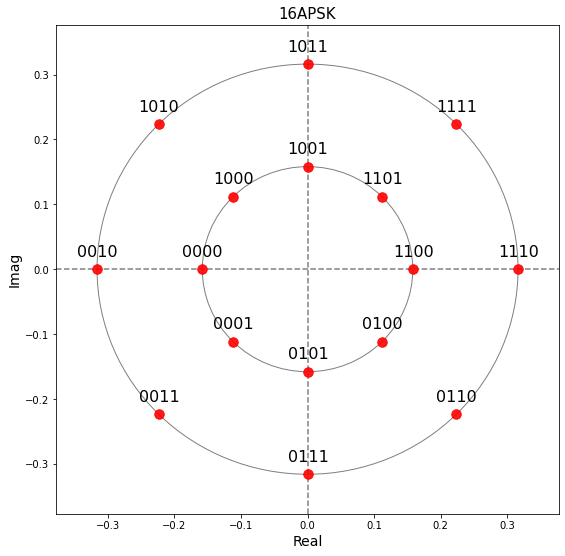

In [ ]:
const = Constellation(2)
const.plot(True)

We can see that Gray codes applied correctly. So difference between any two neighbour points not more then 1 bit.

Now let's create differential modulator

Assume that current state of modulator is:
$$
z_0 = x_0 + jy_0 = r_0 \exp{(j \arctan{\frac{y_0}{x_0}})} = r_0 e^{\phi_0}
$$
And modulator gets signal 
$$
s = x_1 + jy_1 = r_1 \exp{(j \arctan{\frac{y_1}{x_1}})} = r_1 e^{\phi_1}
$$
Then modulator will switch the state to:
$$
z_1 = r_1 e^{\phi_0 + \phi_1}
$$

In [ ]:
class Diff_modulator():
    def __init__(self):
        # state phase of the modulator
        self.cur_phi = 0 

    def modulate(self,z):
        x = z.real 
        y = z.imag
       
        phi = np.arctan2(y,x)
        r = np.sqrt(x**2 + y**2)
        #phase shifting
        cur_phi = phi + self.cur_phi

        #check if phase more than 2pi
        if(cur_phi > 2*np.pi):
            cur_phi %= 2*np.pi
        
        #save new state
        self.cur_phi = cur_phi

        #return coordinates 
        x_out = r*np.cos(cur_phi)
        y_out = r*np.sin(cur_phi)

        return complex(x_out, y_out)
    
    def demodulate(self, z0, z1):
        #previous symbol
        x0, y0 = z0.real, z0.imag
        #current symbol
        x1 ,y1 = z1.real, z1.imag

        phi0 = np.arctan2(y0,x0)
        phi1 = np.arctan2(y1,x1)

        r0 = np.sqrt(x0**2 + y0**2)
        r1 = np.sqrt(x1**2 + y1**2)

        #phase shifting
        cur_phi = phi1-phi0
        
        #coordinates calculating
        x_out = r1*np.cos(cur_phi)
        y_out = r1*np.sin(cur_phi)

        return complex(x_out, y_out)
        

Now let's create a model of AWGN channel. 

Assume that $S$ is signal vector and we are going to apply SNR value to it. Then average signal power will be :
$$
\overline{P} = \overline{S^2}
$$
Noise power in dB according our SNR value:
$$
\sigma = \overline{P} \frac{1}{2 \cdot 10^{0.1 \cdot SNR} }
$$
And as noise is Gaussian then:
$$
n = \sigma N, \hspace{1cm} N \sim {\mathcal {N}}(\mu ,\sigma ^{2})
$$
Here $N$ is random noise vector with the same size as signal $S$.

Influence of AWGN can be described:
$$
S_{rx} = S_{tx} + n
$$ 

In [ ]:
class AWGN_channel():

    def __get_noise(signal, SNR):
        P_signal = np.mean(np.abs(signal)**2)
        D_noise = P_signal / 10**(SNR/10)
        mu = 0
        sigma = np.sqrt(D_noise/2)
        
        noise = np.random.normal(mu,sigma, signal.shape[0]) + 1j*np.random.normal(mu,sigma, signal.shape[0])
        return noise

    def add_noise(signal, SNR):
        noise = AWGN_channel.__get_noise(signal, SNR)
        noisy_signal = signal + noise

        return noisy_signal


Let's consider some specific example


In [ ]:
#create constellation with r_ratio = 2
constellation = Constellation(2)
# create bit stream
bit_stream = generate_data(2**16)
# mapping of bit_stream
transmitted_signal = map_data(bit_stream, constellation.gray_map)
# SNR level 
SNR = 18
# receiveing the signal
received = AWGN_channel.add_noise(transmitted_signal, SNR)
# singal demapping 
demapped_signal = constellation.demapping(received)
# BER calculating
get_ber(bit_stream, demapped_signal[0])
decision = demapped_signal[1]

Now let's plot all the points that were received on the constellation
 

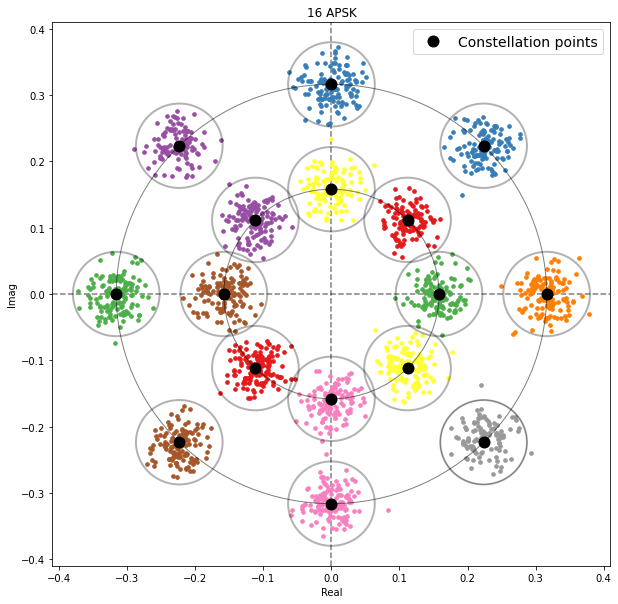

In [ ]:
import matplotlib
a = 0
b = 2000

cmap = matplotlib.cm.get_cmap('Set1')
unique = np.unique(decision[a:b])
np.random.shuffle(unique)

plt.figure(figsize=(10,10))
plt.xlim(-0.41,0.41)
plt.ylim(-0.41,0.41)

# plot constellation points 
plt.plot(constellation.points.real, constellation.points.imag,'o',markersize=10,markeredgewidth = 2, color ='k',label='Constellation points')

# points of recieved signal
for signal, hard in zip(received[a:b], decision[a:b]):
    x = [signal.real, hard.real]
    y = [signal.imag, hard.imag]
    # color for each group
    colr = cmap(np.argwhere(unique == hard)[0][0]/16)
    plt.scatter(x,y, color = colr, s =13)


# plot the circles of the signal variance
variance = np.var(received)
for point in constellation.points:
    circle = plt.Circle((point.real, point.imag), variance, color='k',alpha = 0.3, fill=False,linewidth=2)
    ax=plt.gca()
    ax.add_patch(circle)

# to add a single label
circle = plt.Circle((point.real, point.imag), variance, color='k', fill=False,linewidth=1,alpha = 0.3)
ax=plt.gca()
ax.add_patch(circle)
ax.axhline(0, linestyle='--', color='k',alpha = 0.5, zorder = -1)
ax.axvline(0, linestyle='--', color='k', alpha = 0.5, zorder = -1)

c1 = plt.Circle((0,0), constellation.points[0].real,color = 'k', fill = False,alpha = 0.5)
c2 = plt.Circle((0,0), constellation.points[12].real, color = 'k',alpha = 0.5, fill = False)
ax.add_patch(c1)
ax.add_patch(c2)
ax.set_title("16 APSK")
ax.set_xlabel("Real")
ax.set_ylabel("Imag")
    
plt.legend(loc='upper right', prop={'size': 14})
plt.show()

On the graph we can see clusters of points that match to a specific constellation point (colors for different clusters can repeat). The variance of the noise was denoted as small circles around clusters. 
We can see that our system works correct. 
However on the picture we have good conditions in terms of noise variance: circles almost don't intersect each other. 

Lets create function for doing experiment. 
As input it needs r_ratio and SNR level and it realizes an experiments with these parameters and returns BER.


In [ ]:
def experiment(r_ratio, SNR):
    constellation = Constellation(r_ratio)
    bit_stream = generate_data(2**16)

    transmitted_signal = map_data(bit_stream, constellation.gray_map)
    
    received_signal = AWGN_channel.add_noise(transmitted_signal, SNR)

    demapped_signal = constellation.demapping(received_signal)

    BER = get_Ber(bit_stream, demapped_signal[0])
    
    return BER

Also it's better for each parameters to do several repetitions of experiment and average the result.

In [ ]:
def repeated_experiment(r_ratio, SNR, repeats):
    result = []

    for _ in range(repeats):
        constellation = Constellation(r_ratio)
        bit_stream = generate_data(2**16)

        transmitted_signal = map_data(bit_stream, constellation.gray_map)
        
        received_signal = AWGN_channel.add_noise(transmitted_signal, SNR)

        demapped_signal = constellation.demapping(received_signal)

        BER = get_Ber(bit_stream, demapped_signal[0])
        
        result.append(BER)
    
    res = np.array(result)

    return np.mean(res), np.std(res)
        

Function for BER vs SNR plotting

In [ ]:
def plot_ber(results_mean, results_std, SNR_range, r_val):
    closest = min(results_mean, key=lambda x:abs(x-0.1))
    arg = np.argwhere(results_mean == closest)[0][0]
    value = SNR_range[arg]

    plt.figure(figsize=(10,5))
    plt.title("BER(SNR)", fontsize = 16 )
    plt.plot(SNR_range,results_mean, '.-', label = '$R_{ratio} = $'+str(r_val))
    plt.grid()
    plt.xticks(np.arange(-20,25,5))
    plt.yscale('log')
    plt.xlabel("SNR", fontsize = 14)
    plt.ylabel("BER", fontsize = 14)
    plt.hlines(0.1 ,-20,25, linestyles='--', color = 'r', alpha = 0.8, label = 'BER = 10%')
    plt.scatter(value, closest, color = 'r', s =50, zorder = 5, label = 'SNR = '+str(np.round(value,2)))
    plt.xlim(-20,25);
    plt.legend(prop={'size': 12 });

Let's look on BER vs SNR curve for some R_ratio value. For example 2. 
Also we are interested to get SNR value where for example we have BER of 10%.

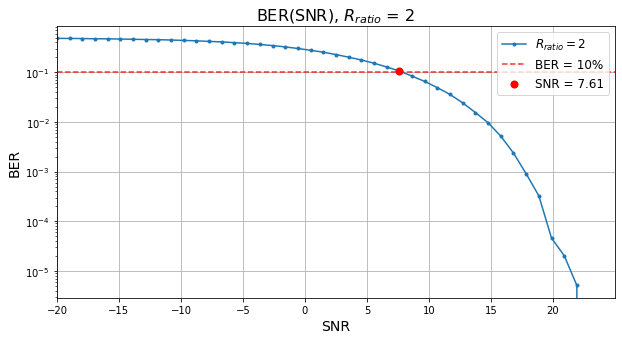

In [ ]:
SNR_range = np.linspace(-20,25, 45)
n_repeats = 3
results_mean = []
results_std = []

for snr in SNR_range:
    result = []
    for repeat in range(n_repeats):
        result.append(experiment(2, snr))
    res = np.array(result)
    results_mean.append(np.mean(res))
    results_std.append(np.std(res))

plot_ber(results_mean, results_std, SNR_range,2)

Now let's choose another R_ratio value and compare the results. For example let 1.1

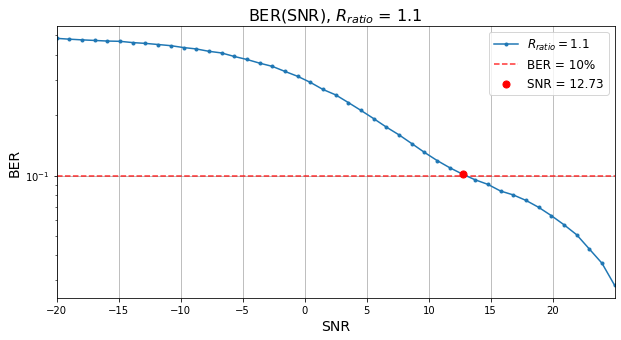

In [ ]:
SNR_range = np.linspace(-20,25, 45)
n_repeats = 3
results_mean = []
results_std = []

for snr in SNR_range:
    result = []
    for repeat in range(n_repeats):
        result.append(experiment(1.1, snr))
    res = np.array(result)
    results_mean.append(np.mean(res))
    results_std.append(np.std(res))

plot_ber(results_mean, results_std, SNR_range,1.1)

in this case constellation points are much closser to each other. As a result we get much more errors. Lets look on case where radiuses are coincides. 

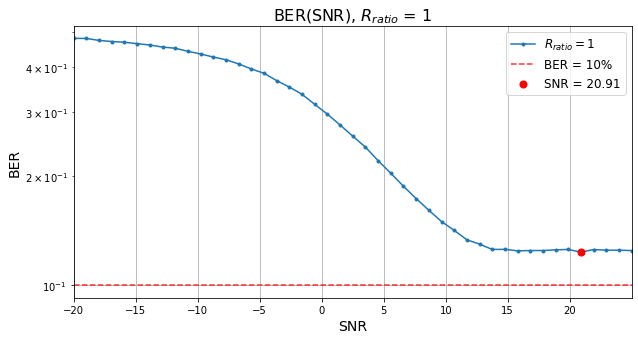

In [ ]:
SNR_range = np.linspace(-20,25, 45)
n_repeats = 3
results_mean = []
results_std = []

for snr in SNR_range:
    result = []
    for repeat in range(n_repeats):
        result.append(experiment(1, snr))
    res = np.array(result)
    results_mean.append(np.mean(res))
    results_std.append(np.std(res))

plot_ber(results_mean, results_std, SNR_range,1)

Of course in this case it's impossible to communicate. Required BER level won't be achived with any SNR value. 

Let's plot a surface with grid of SNR values and r_ratio. Color will describe BER

In [ ]:
range_r_ratio = np.linspace(1.1 , 4, 20)
SNR_range = np.linspace(-20,25, 45)

xx, yy = np.meshgrid(range_r_ratio,SNR_range)

zz = np.empty_like(xx)
zz_std = np.empty_like(xx)

for i,r in enumerate(range_r_ratio):
    for j, snr in enumerate(SNR_range):
        zz[j,i], zz_std[j,i] = repeated_experiment(r,snr,5)


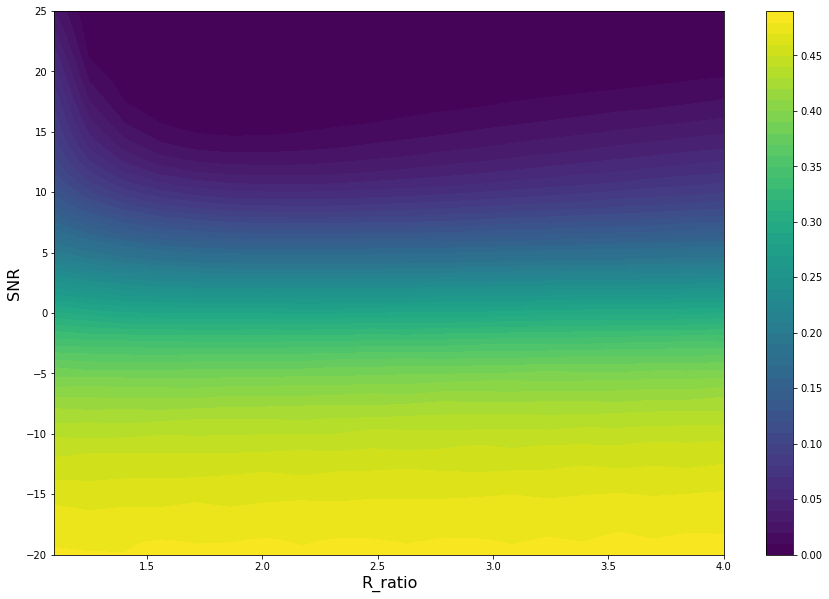

In [ ]:
plt.figure(figsize = (15,10))
plt.contourf(xx,yy,zz, levels= 50)
plt.xlabel("R_ratio", fontsize = 16)
plt.ylabel("SNR", fontsize = 16)
plt.colorbar()

According to this plot we can say that it's unreasonable to tune r_ratio if SNR < 0. Because any configuarion has almost the same error. The reason is obvious - circles of variance intersects each other almost equally with any configuration.  Moreover, it's unreasonable to tune it if SNR >> 20, because in this case almost all comficurations doesn't affect to the result - in this region we have no errors at all. 

Let's look on BER variance with different parameters

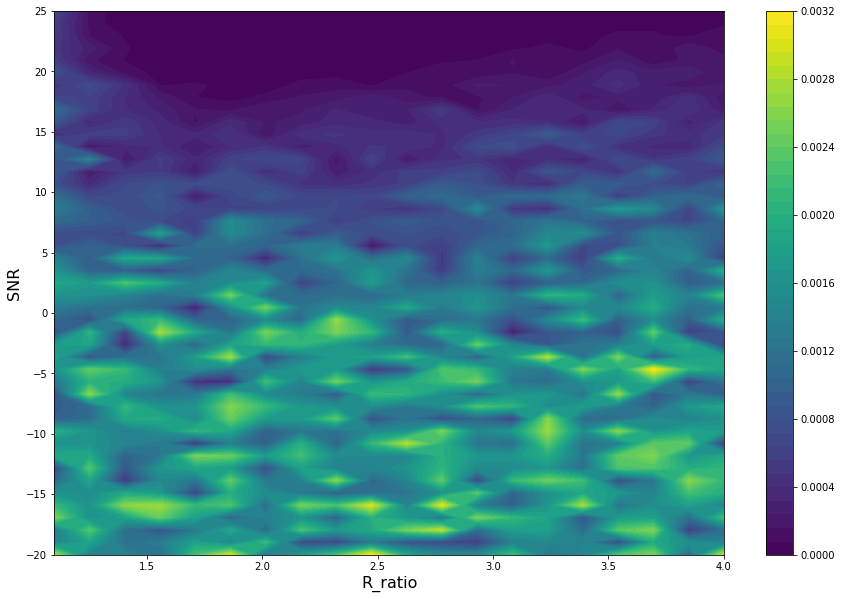

In [ ]:
plt.figure(figsize = (15,10))
plt.contourf(xx,yy,zz_std, levels= 50)
plt.xlabel("R_ratio", fontsize = 16)
plt.ylabel("SNR", fontsize = 16)
plt.colorbar()

We can see that with low SNR (<5) we have unstable results of BER. It means that during optimization, we can easily get stuck in some "local minima" if we use only one experiment on this interval. The higher SNR is the more stable BER is. Also R_ratio depend on it.

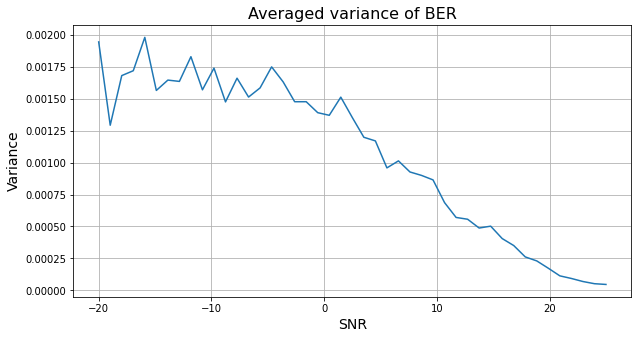

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Averaged variance of BER", fontsize = 16)
plt.xlabel("SNR", fontsize = 14)
plt.ylabel("Variance", fontsize = 14)
plt.plot(np.linspace(-20,25, 45), np.mean(zz_std, axis =1))
plt.grid()

Also we can plot the surface in 3D

Text(0.5, 0, 'BER')

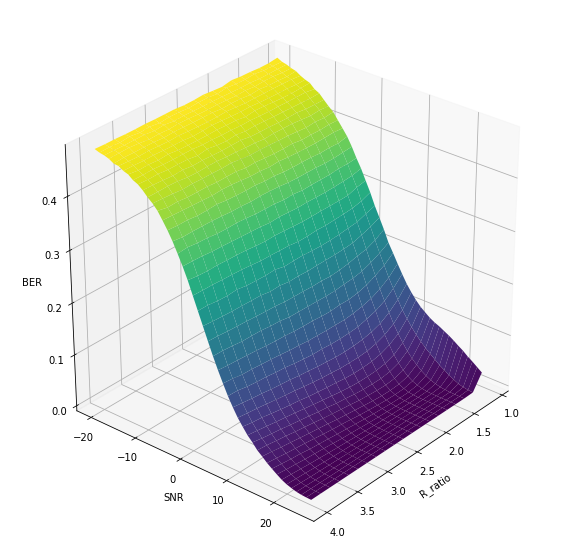

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize =(10,10) )
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30,40)
surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=plt.cm.viridis, linewidth=0, antialiased=True)

ax.set_xlabel('R_ratio')
ax.set_ylabel('SNR')
ax.set_zlabel('BER')


But for some regions (20>SNR>0) we can find an optimal value of R_value, or sets of these values. Let's do it. Here's out function that's going to be optimized

In [ ]:
BER_mean = []
BER_var = []
def function(x):
    ber = []
    for _ in range(5):
        constellation = Constellation(x[0])
        bit_stream = generate_data(2**16)

        transmitted_signal = map_data(bit_stream, constellation.gray_map)
        
        received_signal = AWGN_channel.add_noise(transmitted_signal, snr)

        demapped_signal = constellation.demapping(received_signal)

        BER = get_Ber(bit_stream, demapped_signal[0])
        ber.append(BER)

    res = np.array(ber)
    BER_mean.append(np.mean(res))
    BER_var.append(np.var(res))

    return np.mean(res)

Optimization with 0 order method Nelder-Mead

In [ ]:
from tqdm import tqdm
results = []
for snr in tqdm(np.linspace(0,25, 25)):
    x_min = optimize.minimize(function, x0=[2.5], method='Nelder-Mead')
    results.append(x_min.x)

100%|██████████| 25/25 [23:36<00:00, 56.65s/it]


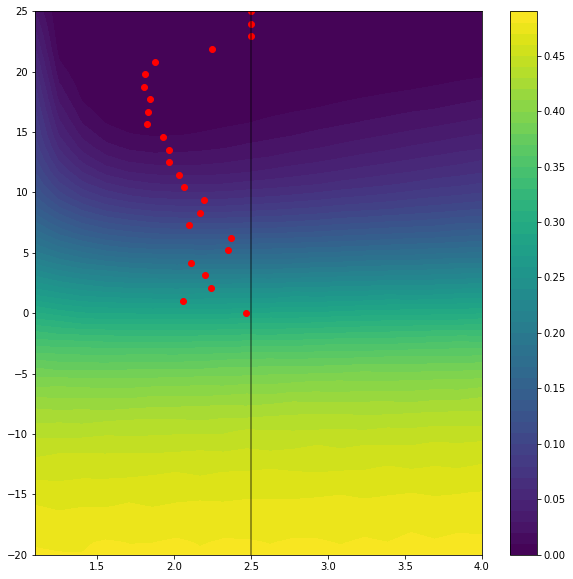

In [ ]:
plt.figure(figsize=(10,10))
# Show the function in 2D
plt.contourf(xx,yy,zz, levels= 50)
plt.colorbar()
# And the minimum that we've found:
plt.scatter(results, np.linspace(0,25, 25), color = 'r')
plt.vlines(2.5, -20, 25,alpha = 0.5)
plt.show()

As a result we can see that for low SNR values we have quite unstable optimal values. As for next points in SNR interval (~7, ~23) they are stable. Next points where SNR > 23 didn't changed their inital point of optimization, because on this interval we have already "optimized" values with 0 errors.   